# Test Gauss-Newton plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features

%load_ext autoreload
%autoreload 2

Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes 

In [4]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

In [5]:
# ax = plot_3D_setup(PC_data[0])
# cmap = cm.get_cmap('viridis')
# cmap_idxs = int(len(cmap.colors) / num_scans) * np.arange(num_scans)
# colors = np.asarray(cmap.colors)[cmap_idxs,:]

# for i, s in enumerate(scans):
#     s.plot(ax, color=colors[i])

Get correspondences

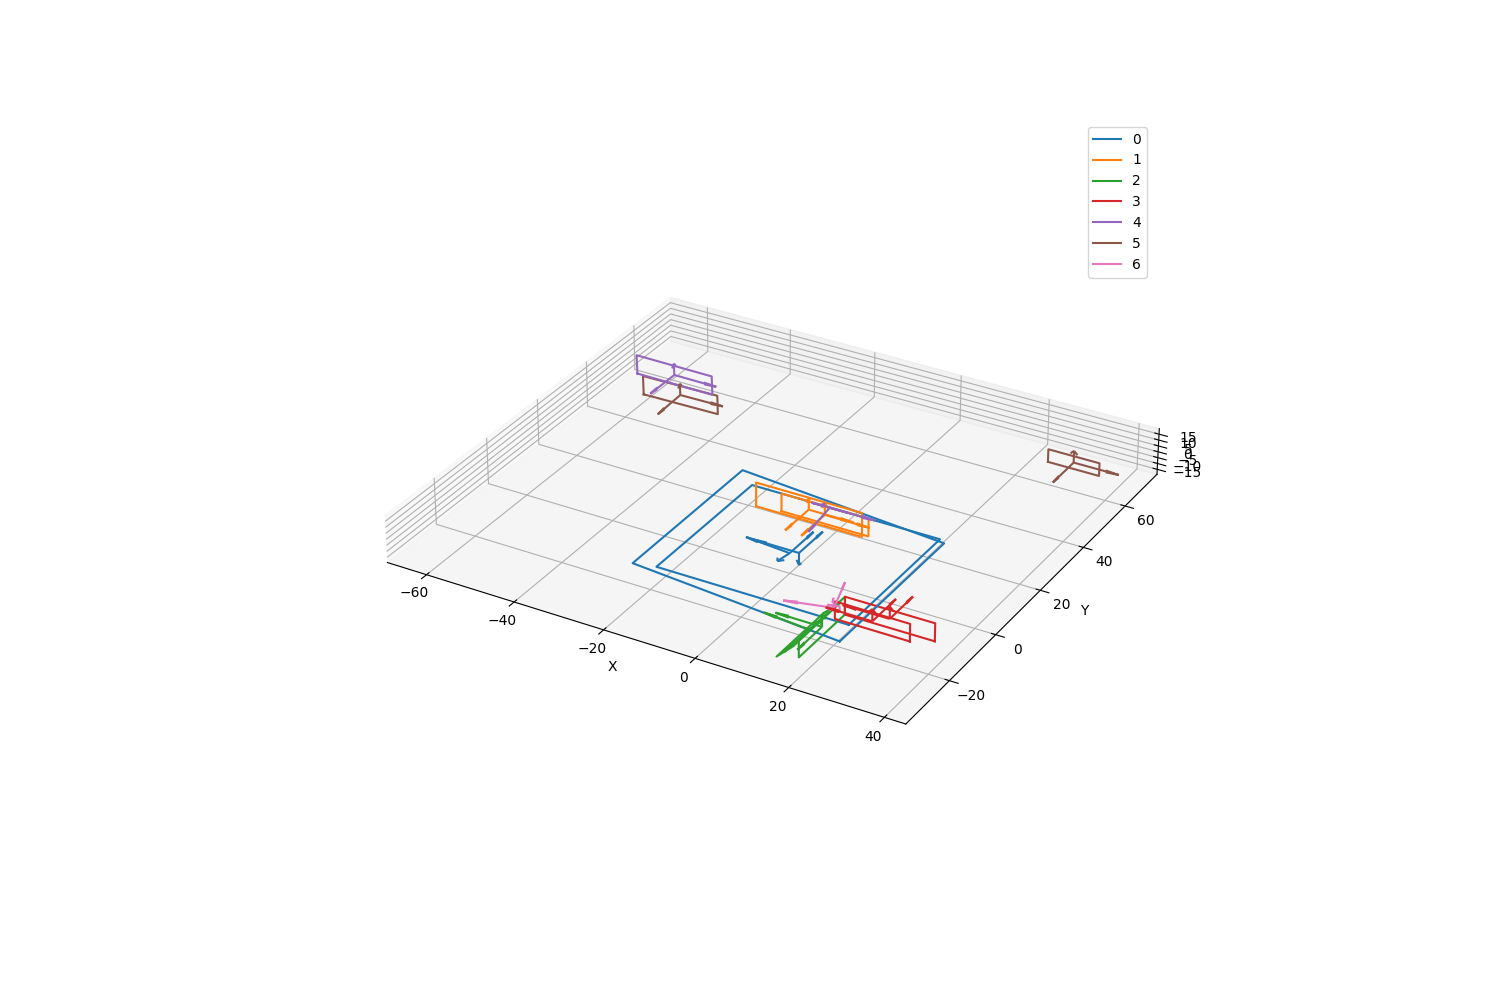

In [6]:
# Plot first 2 scans
ax = plot_3D_setup(PC_data[0])
for i, scan in enumerate(scans[0:2]):
    scan.plot(ax, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax, num_colors)

In [7]:
# Extract normals and distances
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[0], scans[1])

Test Gauss-Newton registration

In [8]:
from planeslam.geometry.util import axis_angle_to_rot_mat, skew


def R_from_q(q):
    """Extract rotation matrix from parameterized transformation q

    Parameters
    ----------
    q : np.array (6 x 1)
        Parameterized transformation

    Returns
    -------
    np.array (3 x 3)
        Rotation matrix
    
    """
    theta = np.linalg.norm(q[3:])  # NOTE: need to wrap?
    if theta == 0:
        return np.eye(3)
    else:
        u = q[3:] / theta 
        return axis_angle_to_rot_mat(u, theta)


def transform_normals(n, q):
    """Transform normals

    n(q) = [...,Rn_i,...]

    Parameters
    ----------
    n : np.array (3N x 1)
        Stacked vector of normals
    q : np.array (6 x 1)
        Parameterized transformation

    Returns
    -------
    np.array (3N x 1)
        Transformed normals

    """
    assert len(n) % 3 == 0, "Invalid normals vector, length should be multiple of 3"
    N = int(len(n) / 3)

    # Extract rotation matrix R from q 
    R = R_from_q(q)

    # Apply R to n
    n = n.reshape((3, N), order='F')
    n = R @ n
    n = n.reshape((3*N, 1), order='F')
    return n


def residual(n_s, d_s, n_t, d_t, q):
    """Residual for Gauss-Newton

    Parameters
    ----------
    n_s : np.array (3N x 1)
        Stacked vector of source normals
    d_s : np.array (N x 1)
        Stacked vector of source distances
    n_t : np.array (3N x 1)
        Stacked vector of target normals
    d_t : np.array (N x 1)
        Stacked vector of target distances
    q : np.array (6 x 1)
        Parameterized transformation

    Returns
    -------
    r : np.array (4N x 1)
        Stacked vector of plane-to-plane error residuals
    n_q : np.array (3N x 1)
        Source normals transformed by q
    
    """
    n_q = transform_normals(n_s, q)

    # Transform distances
    t = q[:3]
    d_q = d_s + n_q.reshape((-1,3)) @ t 

    r = np.vstack((n_q - n_t, d_q - d_t))
    return r, n_q
    

def jacobian(n_s, n_q):
    """Jacobian for Gauss-Newton
    
    Parameters
    ----------
    n_s : np.array (3N x 1)
        Stacked vector of source normals
    n_q : np.array (3N x 1)
        Source normals transformed by q

    Returns
    -------
    J : np.array (4N x 6)
        Jacobian matrix of residual function with respect to q

    """
    assert len(n_s) % 3 == 0, "Invalid normals vector, length should be multiple of 3"
    N = int(len(n_s) / 3)

    J = np.empty((4*N,6))

    for i in range(N):
        Rn_i = n_q[3*i:3*i+3].flatten()
        J[4*i:4*i+3,0:3] = np.zeros((3,3))
        J[4*i:4*i+3,3:6] = skew(Rn_i)
        J[4*i+3,0:3] = -Rn_i
        J[4*i+3,3:6] = np.zeros(3)
    
    return J

In [13]:
# Initial transformation
t = np.array([0, 1, 0])[:,None]
u = np.array([1, 0, 0])[:,None]
theta = 0.1
q = np.vstack((t, theta*u))

print("Initial q: ", np.round(q,2))

# Gauss-Newton
n_iters = 5
lmbda = 1e-3

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    J = jacobian(n_s, n_q)
    q = q - np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r

Initial q:  [[0. ]
 [1. ]
 [0. ]
 [0.1]
 [0. ]
 [0. ]]


In [14]:
q

array([[-201.24413422],
       [-578.92212498],
       [1547.04287038],
       [-129.73356045],
       [-202.61551337],
       [ -46.90837003]])

Test with single plane

In [ ]:
from planeslam.geometry.plane import BoundedPlane
import copy

V = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
P = BoundedPlane(V)

# Ground-truth transformation
t = np.array([0, -2, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/4
q = np.vstack((t, theta*u))

R = R_from_q(q)

In [ ]:
Q = copy.copy(P)
Q.transform(R, t.flatten())

In [ ]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [ ]:
n_s = P.normal 
d_s = np.dot(P.normal.flatten(), P.center)
n_t = Q.normal 
d_t = np.dot(Q.normal.flatten(), Q.center)

In [ ]:
# Initial transformation
t = np.array([0, 1, 0])[:,None]
u = np.array([1, 0, 0])[:,None]
theta = 0.1
q = np.vstack((t, theta*u))


# Gauss-Newton
n_iters = 5

for i in range(n_iters):
    
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    print(r)
    J = jacobian(n_s, n_q)
    print(J)
    q = q - np.linalg.inv(J.T @ J) @ J.T @ r